In [10]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.exceptions import ConvergenceWarning
import warnings

warnings.filterwarnings("ignore", category=ConvergenceWarning)

data = pd.read_csv('./bg_info.csv')
data = data.drop(columns=['Type 2', 'Price'])
data = data.loc[data.drop(columns=['Type 1']).notnull().all(axis=1)]
data['ToRemove'] = False

def mark_outliers_quantile(df, column):
    Q1, Q3 = df[column].quantile([0.25, 0.75])
    IQR = Q3 - Q1
    lower, upper = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
    df.loc[(df[column] < lower) | (df[column] > upper), 'ToRemove'] = True

def mark_outliers_sigma(df, column):
    mean, std = df[column].mean(), df[column].std()
    lower, upper = mean - 3 * std, mean + 3 * std
    df.loc[(df[column] < lower) | (df[column] > upper), 'ToRemove'] = True

quantile_columns = ['Min time', 'Max time']
sigma_columns = ['Geek Rating', 'Complexity', 'Avg rating', 'Num of voters']

for col in quantile_columns:
    mark_outliers_quantile(data, col)
for col in sigma_columns:
    mark_outliers_sigma(data, col)

data = data[data['ToRemove'] == False].drop(columns=['ToRemove'])
data = data[(data['Year'] >= 1950) & (data['Year'] < 2025) & (data['Complexity'] != 0.0)]

bins = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, float('inf')]
labels = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11-15', '16-20', '>20']
data['Max_players_category'] = pd.cut(data['Max players'], bins=bins, labels=labels, include_lowest=True)
data['Age_category'] = pd.cut(data['Age'], bins=bins, labels=labels, include_lowest=True)
data['Min_players_category'] = data['Min players'].astype('category')
data = data.drop(columns=['Age', 'Max players', 'Min players', 'Title'])
data = pd.get_dummies(data, columns=['Type 1'], drop_first=True)

data = data.apply(lambda col: col.cat.codes + 1 if col.dtype.name == 'category' else col)
X, y = data.drop(columns=['Num of voters']), data['Num of voters']
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=2137)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=2137)

scaler = StandardScaler()
X_train_scaled, X_val_scaled, X_test_scaled = scaler.fit_transform(X_train), scaler.transform(X_val), scaler.transform(X_test)

def calculate_percentage_within_margin(y_true, y_pred, margin=0.1):
    lower, upper = y_true * (1 - margin), y_true * (1 + margin)
    return str(round((sum((y_pred >= lower) & (y_pred <= upper)) / len(y_true)) * 100, 2)) + "%"


Epoch 1/5000
373/398 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step - loss: 1279428.5000 - mae: 467.4520
Epoch 1: val_loss improved from inf to 983366.12500, saving model to model_checkpoints\2_layers.weights.h5
398/398 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1271126.2500 - mae: 464.9948 - val_loss: 983366.1250 - val_mae: 387.8446
Epoch 2/5000
375/398 ━━━━━━━━━━━━━━━━━━━━ 0s 946us/step - loss: 628432.7500 - mae: 344.3607
Epoch 2: val_loss improved from 983366.12500 to 637164.00000, saving model to model_checkpoints\2_layers.weights.h5
398/398 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 625241.3125 - mae: 344.2536 - val_loss: 637164.0000 - val_mae: 342.9552
Epoch 3/5000
374/398 ━━━━━━━━━━━━━━━━━━━━ 0s 949us/step - loss: 439692.5000 - mae: 301.9053
Epoch 3: val_loss improved from 637164.00000 to 518201.46875, saving model to model_checkpoints\2_layers.weights.h5
398/398 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 438640.9688 - mae: 300.9649 - val_loss: 518201.4688 - val_mae: 285.1031
Epoch 4/5000
390/398

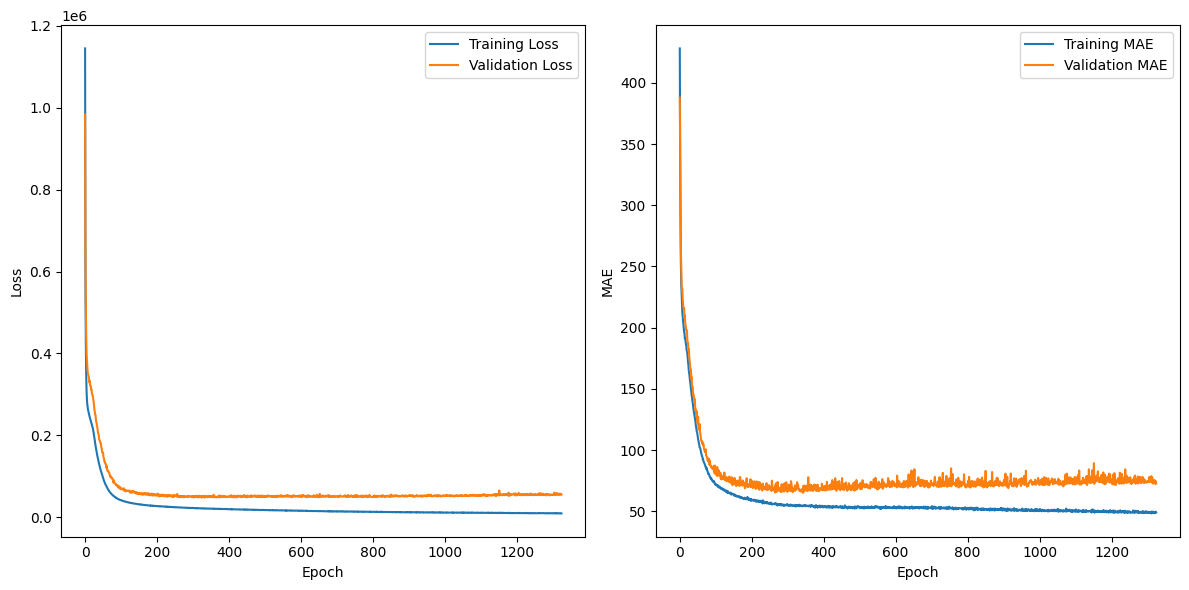

In [11]:

checkpoint_dir = "model_checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)
checkpoint_path = os.path.join(checkpoint_dir, "2_layers.weights.h5")

model = keras.Sequential([
    keras.Input(shape=(X_train_scaled.shape[1],)),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])
checkpoint_callback = ModelCheckpoint(filepath=checkpoint_path, monitor="val_loss", save_best_only=True, save_weights_only=True, mode="min", verbose=1)
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=1000, restore_best_weights=True)

history = model.fit(X_train_scaled, y_train, epochs=5000, batch_size=32, validation_data=(X_val_scaled, y_val), verbose=1, callbacks=[early_stopping, checkpoint_callback])

loss, mae = model.evaluate(X_test_scaled, y_test, verbose=1)
y_pred = model.predict(X_test_scaled).flatten()
rmse = np.sqrt(loss)
margin_accuracy = calculate_percentage_within_margin(y_test, y_pred)

print(f'Loss: {loss}, MAE: {mae}, RMSE: {rmse}, Accuracy within margin: {margin_accuracy}')

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.tight_layout()
plt.show()


Epoch 1/5000
378/398 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1196846.0000 - mae: 461.9126
Epoch 1: val_loss improved from inf to 584542.43750, saving model to model_checkpoints\4_layers.weights.h5
398/398 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 1179830.1250 - mae: 458.8129 - val_loss: 584542.4375 - val_mae: 309.6083
Epoch 2/5000
358/398 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 371582.5938 - mae: 270.8965
Epoch 2: val_loss improved from 584542.43750 to 399462.59375, saving model to model_checkpoints\4_layers.weights.h5
398/398 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 368659.8438 - mae: 269.4962 - val_loss: 399462.5938 - val_mae: 234.0454
Epoch 3/5000
388/398 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 237767.3438 - mae: 206.5667
Epoch 3: val_loss improved from 399462.59375 to 343638.00000, saving model to model_checkpoints\4_layers.weights.h5
398/398 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 238356.7812 - mae: 206.6997 - val_loss: 343638.0000 - val_mae: 225.5612
Epoch 4/5000
375/398 ━━━━━

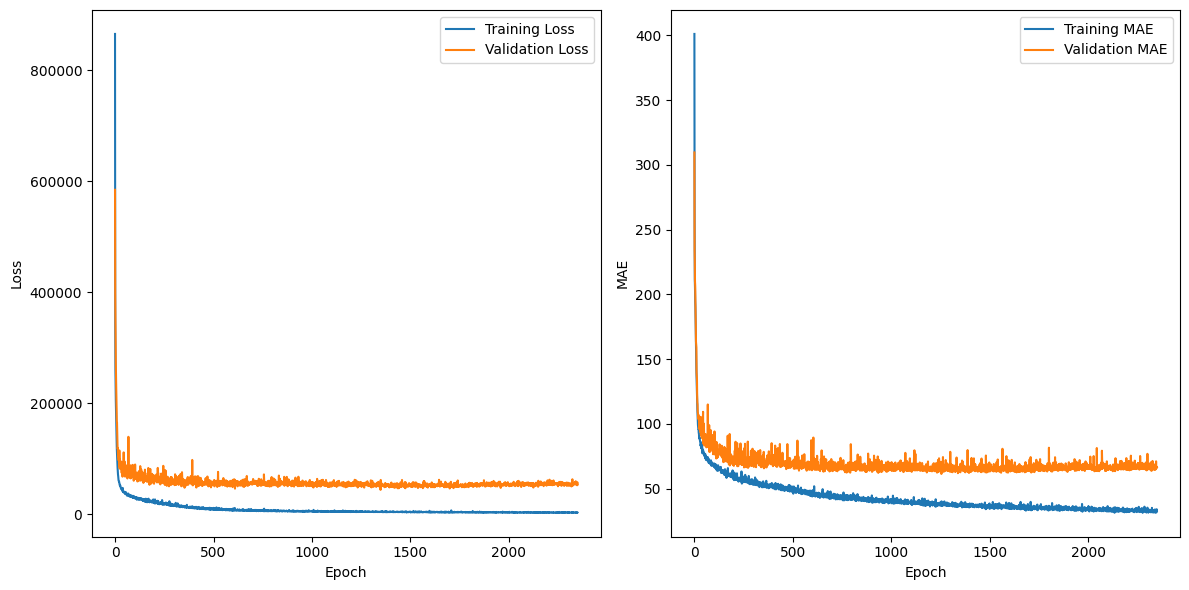

In [12]:

checkpoint_dir = "model_checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)
checkpoint_path = os.path.join(checkpoint_dir, "4_layers.weights.h5")

model = keras.Sequential([
    keras.Input(shape=(X_train_scaled.shape[1],)),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(8, activation='relu'),
    layers.Dense(1)
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])
checkpoint_callback = ModelCheckpoint(filepath=checkpoint_path, monitor="val_loss", save_best_only=True, save_weights_only=True, mode="min", verbose=1)
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=1000, restore_best_weights=True)

history = model.fit(X_train_scaled, y_train, epochs=5000, batch_size=32, validation_data=(X_val_scaled, y_val), verbose=1, callbacks=[early_stopping, checkpoint_callback])

loss, mae = model.evaluate(X_test_scaled, y_test, verbose=1)
y_pred = model.predict(X_test_scaled).flatten()
rmse = np.sqrt(loss)
margin_accuracy = calculate_percentage_within_margin(y_test, y_pred)

print(f'Loss: {loss}, MAE: {mae}, RMSE: {rmse}, Accuracy within margin: {margin_accuracy}')

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.tight_layout()
plt.show()


Epoch 1/5000
357/398 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1036493.2500 - mae: 438.4308
Epoch 1: val_loss improved from inf to 411319.03125, saving model to model_checkpoints\5_layers.weights.h5
398/398 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 998092.2500 - mae: 429.7466 - val_loss: 411319.0312 - val_mae: 237.9693
Epoch 2/5000
386/398 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 312074.5312 - mae: 223.1913
Epoch 2: val_loss improved from 411319.03125 to 317189.68750, saving model to model_checkpoints\5_layers.weights.h5
398/398 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 310035.3750 - mae: 222.7633 - val_loss: 317189.6875 - val_mae: 202.4698
Epoch 3/5000
363/398 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 188966.4844 - mae: 189.3484
Epoch 3: val_loss improved from 317189.68750 to 255384.40625, saving model to model_checkpoints\5_layers.weights.h5
398/398 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 188958.0781 - mae: 188.7598 - val_loss: 255384.4062 - val_mae: 186.4464
Epoch 4/5000
391/398 ━━━━━━

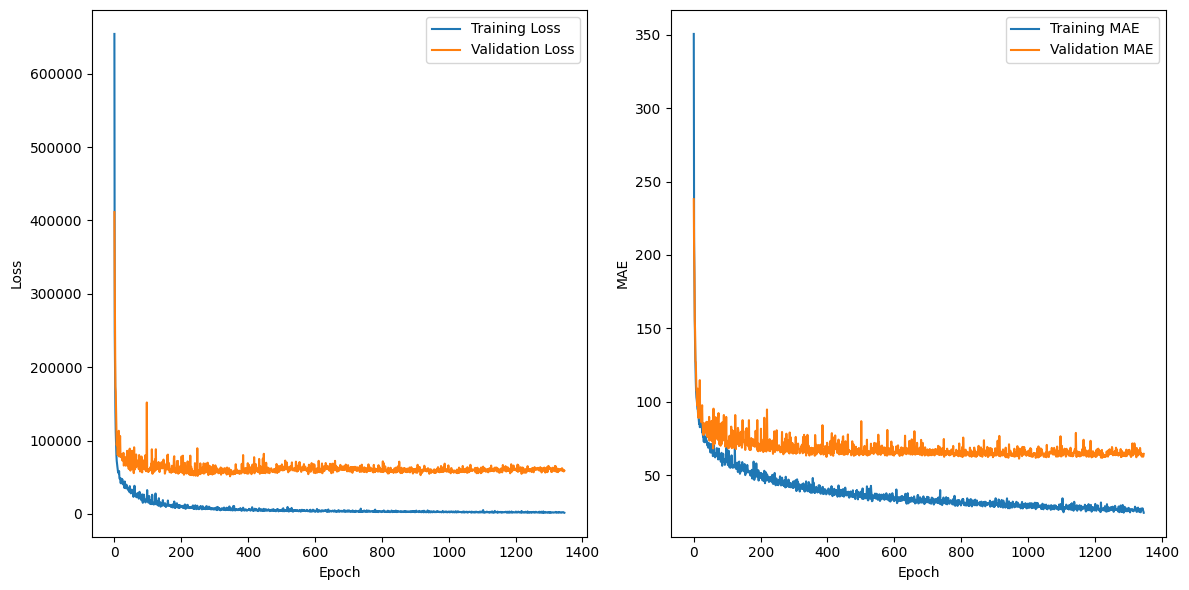

In [19]:

checkpoint_dir = "model_checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)
checkpoint_path = os.path.join(checkpoint_dir, "5_layers.weights.h5")

model = keras.Sequential([
    keras.Input(shape=(X_train_scaled.shape[1],)),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(8, activation='relu'),
    layers.Dense(1)
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])
checkpoint_callback = ModelCheckpoint(filepath=checkpoint_path, monitor="val_loss", save_best_only=True, save_weights_only=True, mode="min", verbose=1)
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=1000, restore_best_weights=True)

history = model.fit(X_train_scaled, y_train, epochs=5000, batch_size=32, validation_data=(X_val_scaled, y_val), verbose=1, callbacks=[early_stopping, checkpoint_callback])

loss, mae = model.evaluate(X_test_scaled, y_test, verbose=1)
y_pred = model.predict(X_test_scaled).flatten()
rmse = np.sqrt(loss)
margin_accuracy = calculate_percentage_within_margin(y_test, y_pred)

print(f'Loss: {loss}, MAE: {mae}, RMSE: {rmse}, Accuracy within margin: {margin_accuracy}')

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.tight_layout()
plt.show()


Epoch 1/5000
368/398 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 894383.4375 - mae: 398.7484
Epoch 1: val_loss improved from inf to 321352.59375, saving model to model_checkpoints\6_layers.weights.h5
398/398 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 865048.7500 - mae: 391.5472 - val_loss: 321352.5938 - val_mae: 211.7241
Epoch 2/5000
396/398 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 212057.7969 - mae: 194.0978
Epoch 2: val_loss improved from 321352.59375 to 210597.07812, saving model to model_checkpoints\6_layers.weights.h5
398/398 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 211874.3125 - mae: 194.0022 - val_loss: 210597.0781 - val_mae: 161.2625
Epoch 3/5000
386/398 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 150880.0156 - mae: 157.4600
Epoch 3: val_loss improved from 210597.07812 to 148972.64062, saving model to model_checkpoints\6_layers.weights.h5
398/398 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 150079.7188 - mae: 157.0387 - val_loss: 148972.6406 - val_mae: 144.3410
Epoch 4/5000
384/398 ━━━━━━━

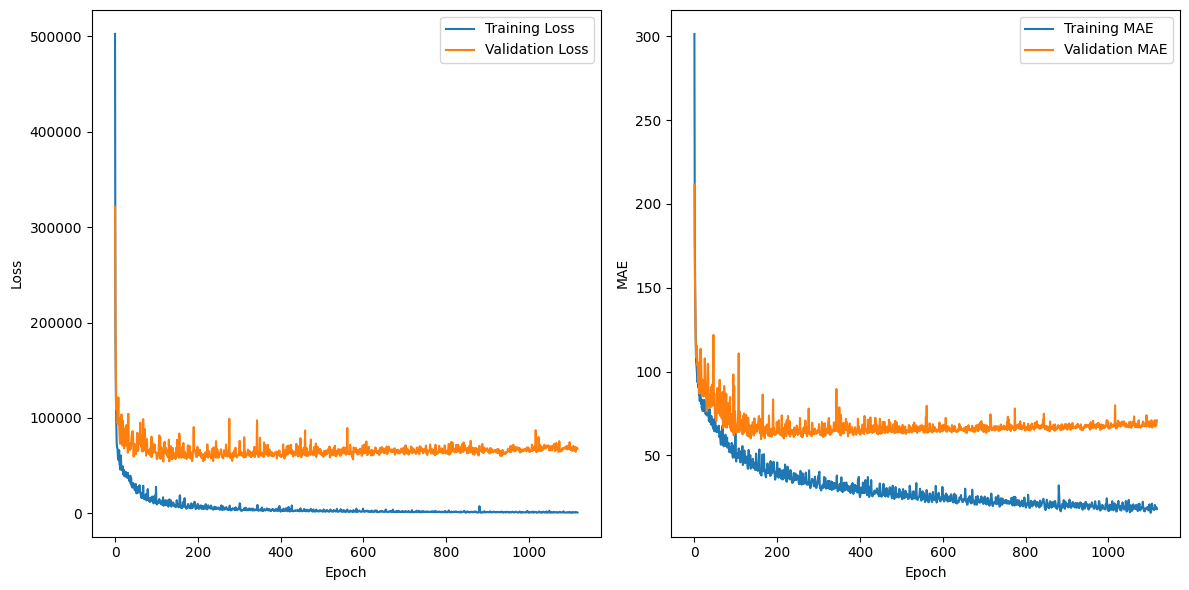

In [18]:

checkpoint_dir = "model_checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)
checkpoint_path = os.path.join(checkpoint_dir, "6_layers.weights.h5")

model = keras.Sequential([
    keras.Input(shape=(X_train_scaled.shape[1],)),
    layers.Dense(256, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(8, activation='relu'),
    layers.Dense(1)
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])
checkpoint_callback = ModelCheckpoint(filepath=checkpoint_path, monitor="val_loss", save_best_only=True, save_weights_only=True, mode="min", verbose=1)
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=1000, restore_best_weights=True)

history = model.fit(X_train_scaled, y_train, epochs=5000, batch_size=32, validation_data=(X_val_scaled, y_val), verbose=1, callbacks=[early_stopping, checkpoint_callback])

loss, mae = model.evaluate(X_test_scaled, y_test, verbose=1)
y_pred = model.predict(X_test_scaled).flatten()
rmse = np.sqrt(loss)
margin_accuracy = calculate_percentage_within_margin(y_test, y_pred)

print(f'Loss: {loss}, MAE: {mae}, RMSE: {rmse}, Accuracy within margin: {margin_accuracy}')

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.tight_layout()
plt.show()


Epoch 1/5000
396/398 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 526296.4375 - mae: 314.7954
Epoch 1: val_loss improved from inf to 230116.68750, saving model to model_checkpoints\8_layers.weights.h5
398/398 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 524798.1875 - mae: 314.2313 - val_loss: 230116.6875 - val_mae: 193.0889
Epoch 2/5000
393/398 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 150038.8750 - mae: 159.6699
Epoch 2: val_loss improved from 230116.68750 to 144492.06250, saving model to model_checkpoints\8_layers.weights.h5
398/398 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 149816.6094 - mae: 159.5539 - val_loss: 144492.0625 - val_mae: 131.3941
Epoch 3/5000
397/398 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 104541.2969 - mae: 131.8736
Epoch 3: val_loss improved from 144492.06250 to 134080.18750, saving model to model_checkpoints\8_layers.weights.h5
398/398 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 104571.4531 - mae: 131.8925 - val_loss: 134080.1875 - val_mae: 135.7924
Epoch 4/5000
396/398 ━━━━━━━

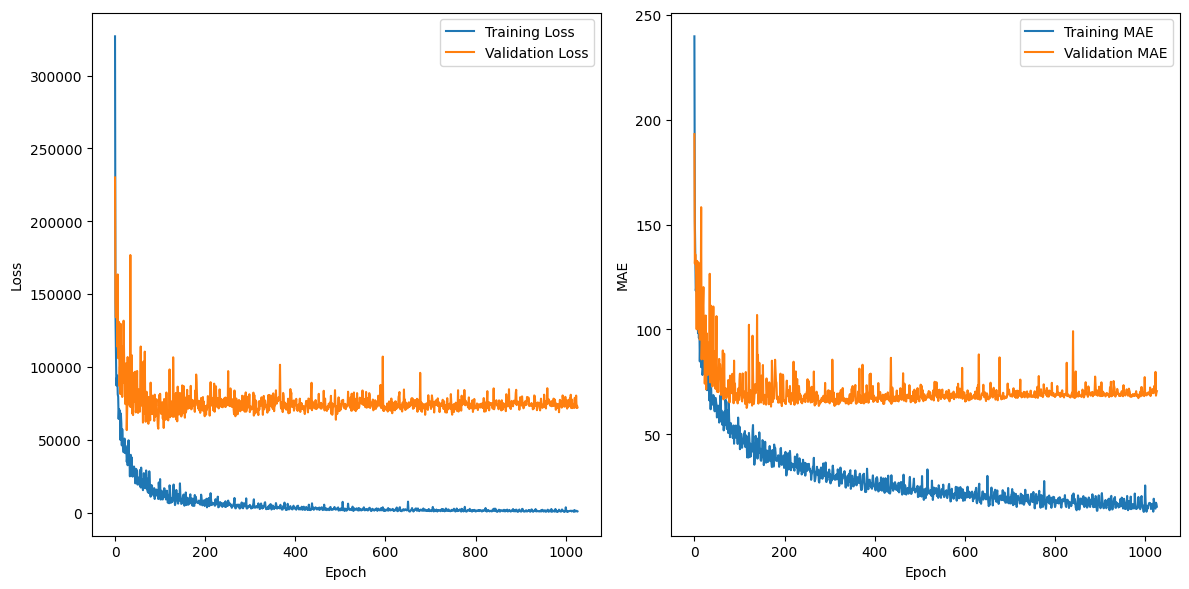

In [15]:

checkpoint_dir = "model_checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)
checkpoint_path = os.path.join(checkpoint_dir, "8_layers.weights.h5")

model = keras.Sequential([
    keras.Input(shape=(X_train_scaled.shape[1],)),
    layers.Dense(1028, activation='relu'),
    layers.Dense(512, activation='relu'),
    layers.Dense(256, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(8, activation='relu'),
    layers.Dense(1)
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])
checkpoint_callback = ModelCheckpoint(filepath=checkpoint_path, monitor="val_loss", save_best_only=True, save_weights_only=True, mode="min", verbose=1)
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=1000, restore_best_weights=True)

history = model.fit(X_train_scaled, y_train, epochs=5000, batch_size=32, validation_data=(X_val_scaled, y_val), verbose=1, callbacks=[early_stopping, checkpoint_callback])

loss, mae = model.evaluate(X_test_scaled, y_test, verbose=1)
y_pred = model.predict(X_test_scaled).flatten()
rmse = np.sqrt(loss)
margin_accuracy = calculate_percentage_within_margin(y_test, y_pred)

print(f'Loss: {loss}, MAE: {mae}, RMSE: {rmse}, Accuracy within margin: {margin_accuracy}')

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.tight_layout()
plt.show()



Epoch 1: LearningRateScheduler setting learning rate to 0.002.
Epoch 1/5000
377/398 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 726773.6875 - mae: 358.0964
Epoch 1: val_loss improved from inf to 243789.59375, saving model to model_checkpoints\6_layers_learning_rate_schedule.weights.h5
398/398 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 709561.5000 - mae: 352.9767 - val_loss: 243789.5938 - val_mae: 195.7511 - learning_rate: 0.0020

Epoch 2: LearningRateScheduler setting learning rate to 0.003.
Epoch 2/5000
366/398 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 206053.7656 - mae: 184.9200
Epoch 2: val_loss improved from 243789.59375 to 202684.17188, saving model to model_checkpoints\6_layers_learning_rate_schedule.weights.h5
398/398 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 203715.3750 - mae: 183.8881 - val_loss: 202684.1719 - val_mae: 156.2484 - learning_rate: 0.0030

Epoch 3: LearningRateScheduler setting learning rate to 0.005.
Epoch 3/5000
388/398 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 193584.

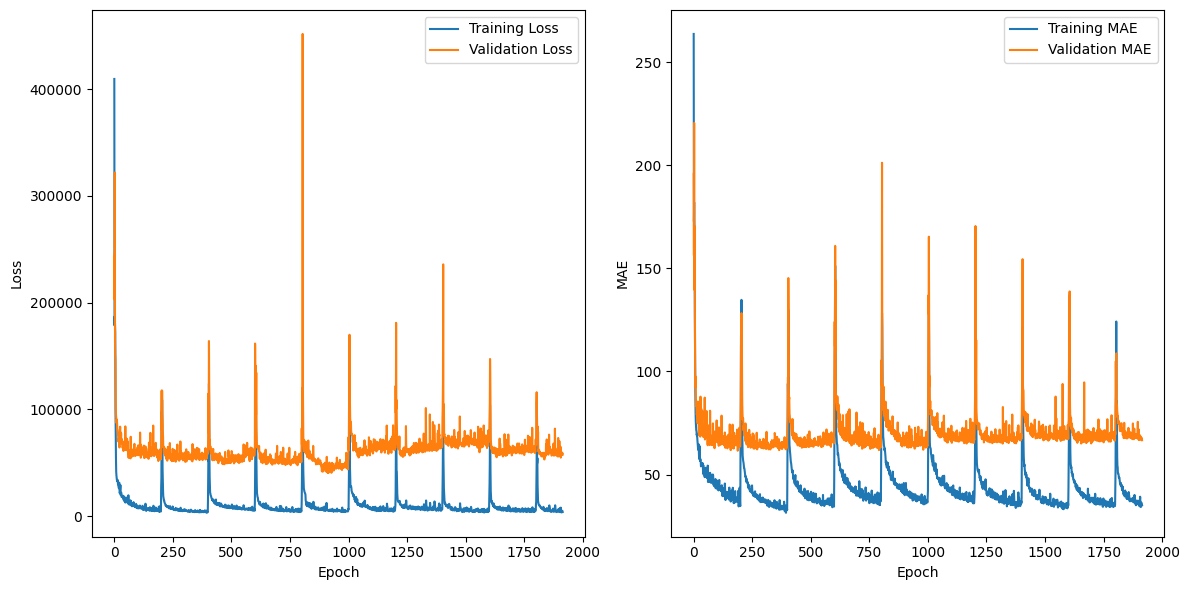

In [20]:
from tensorflow.keras.callbacks import LearningRateScheduler

checkpoint_dir = "model_checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)
checkpoint_path = os.path.join(checkpoint_dir, "6_layers_learning_rate_schedule.weights.h5")
basic_lr = 0.001
def lr_schedule(epoch, lr):
    multipliers = [2, 3, 5, 7, 11, 7, 5, 3, 2]
    cycle_position = epoch%200
    if cycle_position > 8:
        return basic_lr
    return basic_lr * multipliers[cycle_position]

lr_scheduler = LearningRateScheduler(lr_schedule, verbose=1)

model = keras.Sequential([
    keras.Input(shape=(X_train_scaled.shape[1],)),
    layers.Dense(256, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(8, activation='relu'),
    layers.Dense(1)
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])
checkpoint_callback = ModelCheckpoint(filepath=checkpoint_path, monitor="val_loss", save_best_only=True, save_weights_only=True, mode="min", verbose=1)
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=1000, restore_best_weights=True)

history = model.fit(X_train_scaled, y_train, epochs=5000, batch_size=32, validation_data=(X_val_scaled, y_val), verbose=1, callbacks=[early_stopping, checkpoint_callback, lr_scheduler])

loss, mae = model.evaluate(X_test_scaled, y_test, verbose=1)
y_pred = model.predict(X_test_scaled).flatten()
rmse = np.sqrt(loss)
margin_accuracy = calculate_percentage_within_margin(y_test, y_pred)

print(f'Loss: {loss}, MAE: {mae}, RMSE: {rmse}, Accuracy within margin: {margin_accuracy}')

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.tight_layout()
plt.show()
